In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import category_encoders as ce

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline


import xgboost as xgb

#import lightgbm as lgbm

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Loading Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [6]:
data = []
for f in train.columns:
    
    #defining the role
    
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
    
    #defining the level
    
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    #initialiation to distinguise ID
    keep = True
    if f == 'id':
        keep = False
        
    #Data type
    dtype = train[f].dtype
    
    # dictionary with metadata
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

meta = pd.DataFrame(data, columns = ['varname', 'role', 'level',
                                    'keep', 'dtype'])
meta.set_index('varname', inplace = True)

In [7]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [8]:
pd.DataFrame({'count': meta.groupby(['role', 'level']).size()})

count
role   level          
id     nominal       1
input  binary       17
       interval     10
       nominal      14
       ordinal      16
target binary        1

# Target Visualization

<Figure size 432x288 with 0 Axes>

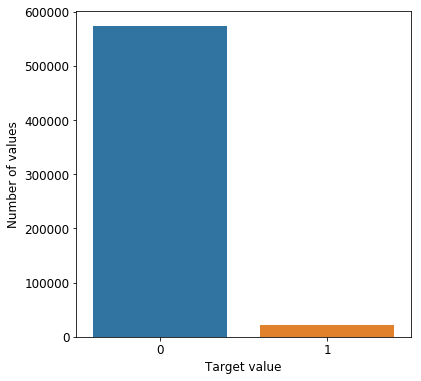

In [9]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = train['target'].value_counts().index.values
y = train["target"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Nominal variables

In [10]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

# Describe Interval and ordinal variables

## Interval variables

In [11]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
v

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object', name='varname')

In [12]:
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


## Ordinal Variables

In [13]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


# Balancing the imbalanced data

#### target is imbalanced ( mean = 0.04), so I used undersampling records with target = 0 (desired apriori to be 0.1 rather than 0.04)

In [14]:
desired_apriori = 0.1

# Get the indicies per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target = 0

undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)

#Randomly select records with target = 0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state = 37, 
                           n_samples = undersampled_nb_0)

#construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# return undersampled data frame
train = train.loc[idx_list].reset_index(drop = True)

In [15]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,353762,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,11,1,-1,0,-1,6,1,1,2,1,26,1,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1
1,845629,0,5,1,7,1,1,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,7,1,-1,0,-1,14,1,1,2,1,104,1,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0
2,1449185,0,4,1,3,1,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,11,1,-1,0,-1,3,1,1,2,1,15,3,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1
3,834066,0,6,1,6,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,6,1,-1,0,0,1,1,1,0,1,74,2,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0
4,436189,0,5,1,5,0,0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,5,1,-1,0,-1,0,0,1,0,1,78,3,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1


# Checking missing variables

In [16]:
train[train['ps_car_14'] == -1]['ps_car_14'].count()

15726

In [17]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


### interval (continuous) -> replace by the mean  
### ordinal -> replace by the mode  
### nominal (categorical) -> check it later

ps_car_03_cat and ps_car_05_cat have a large proportion of records with missing values. Remove these variables.

In [18]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace = True, axis = 1)

#Updating the metadata
meta.loc[(vars_to_drop), 'keep'] = False 

In [19]:
#Imputing null with mean or mode
mean_imp = Imputer(missing_values = -1, 
                   strategy = 'mean', axis = 0)
mode_imp = Imputer(missing_values = -1,
                  strategy = 'most_frequent', axis = 0)
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Checking the Cardinality (nominal, ordinal) 

check the number of different values in a variable

In [20]:
v = meta[((meta.level == 'nominal') | (meta.level == 'ordinal'))
         & (meta.keep)].index
for f in v:
    dist_values = train[f].value_counts().shape[0]
    print(f, ':', dist_values)

ps_ind_01 : 8
ps_ind_02_cat : 5
ps_ind_03 : 12
ps_ind_04_cat : 3
ps_ind_05_cat : 8
ps_ind_14 : 5
ps_ind_15 : 14
ps_car_01_cat : 13
ps_car_02_cat : 3
ps_car_04_cat : 10
ps_car_06_cat : 18
ps_car_07_cat : 3
ps_car_08_cat : 2
ps_car_09_cat : 6
ps_car_10_cat : 3
ps_car_11_cat : 104
ps_car_11 : 4
ps_calc_04 : 6
ps_calc_05 : 7
ps_calc_06 : 10
ps_calc_07 : 10
ps_calc_08 : 11
ps_calc_09 : 8
ps_calc_10 : 25
ps_calc_11 : 19
ps_calc_12 : 11
ps_calc_13 : 14
ps_calc_14 : 24


# Visualization

## nominal variable

visualizing with for loop
also check for '-1' (missing) values

show graph with y axis (percentage of target)

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

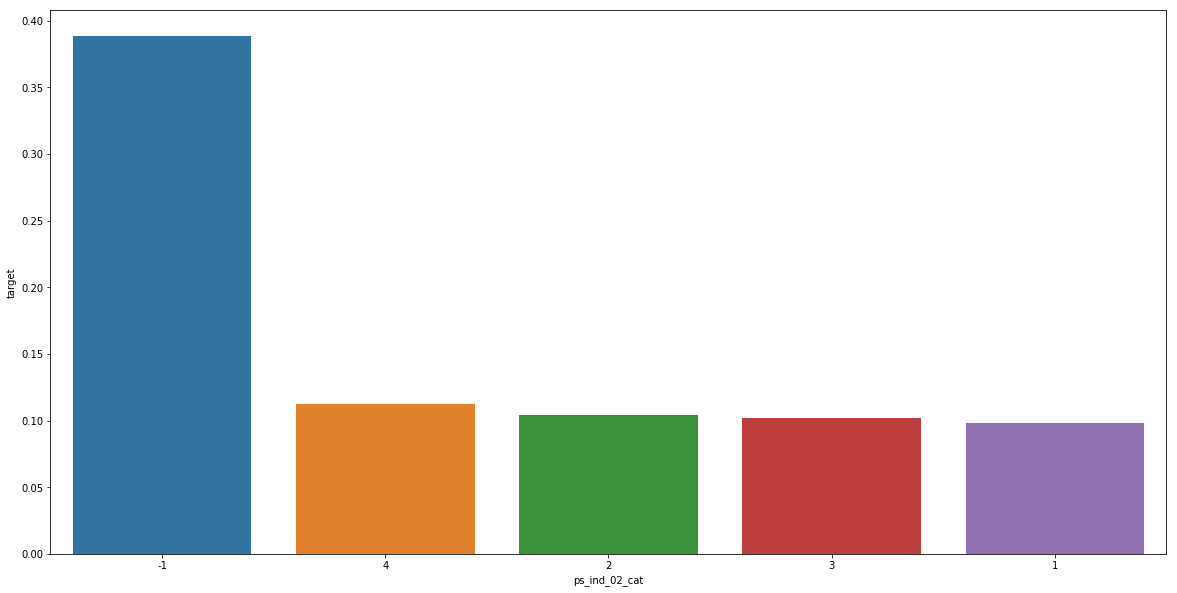

<Figure size 432x288 with 0 Axes>

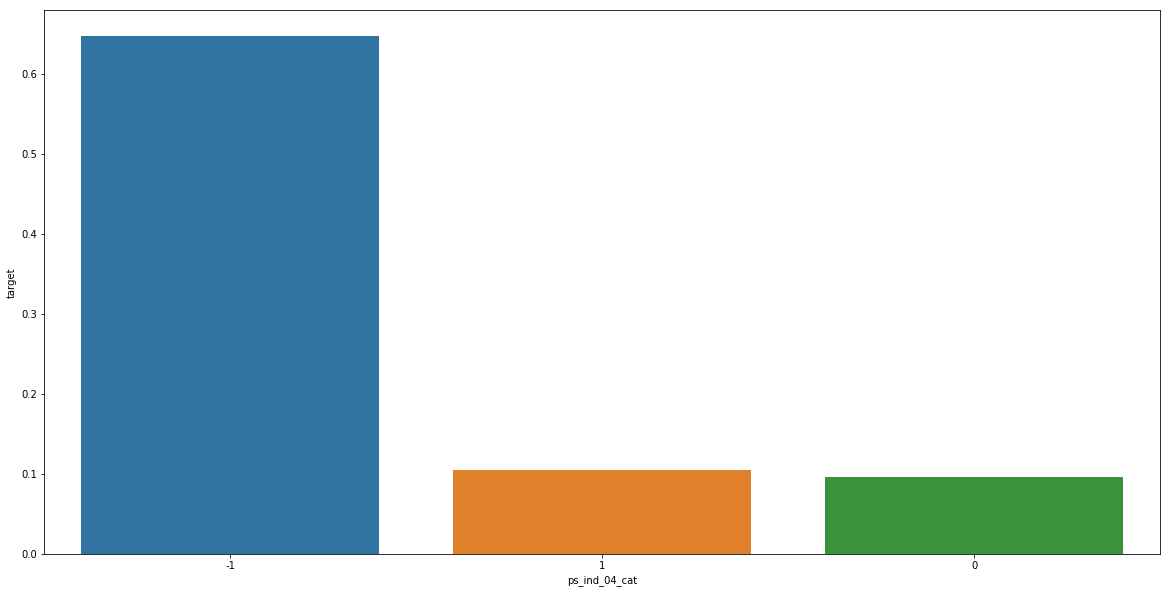

<Figure size 432x288 with 0 Axes>

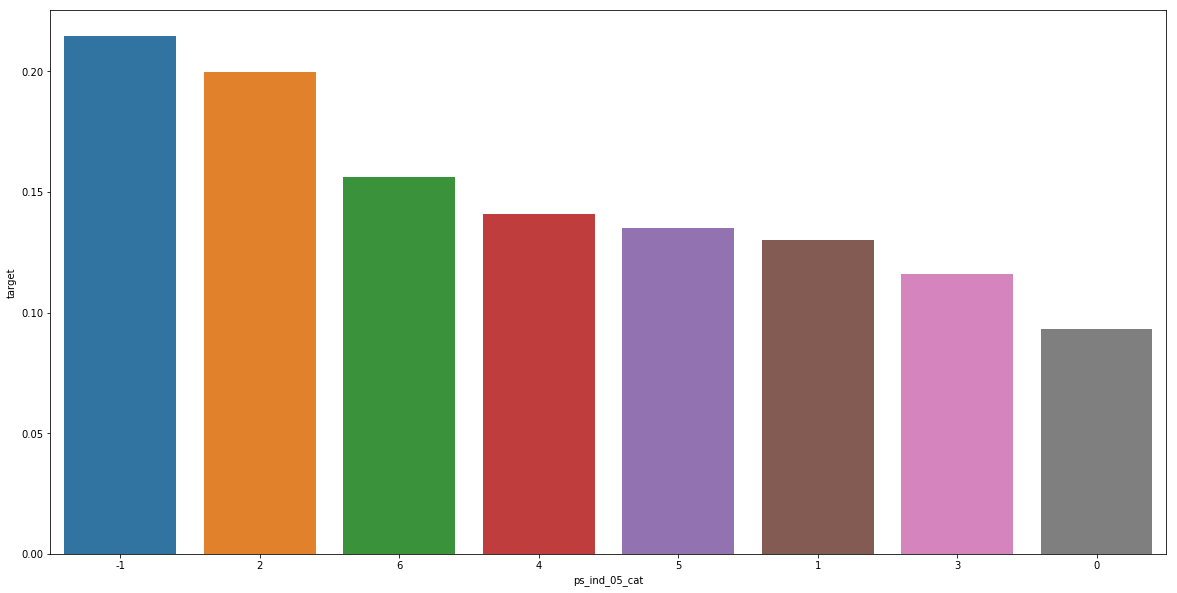

<Figure size 432x288 with 0 Axes>

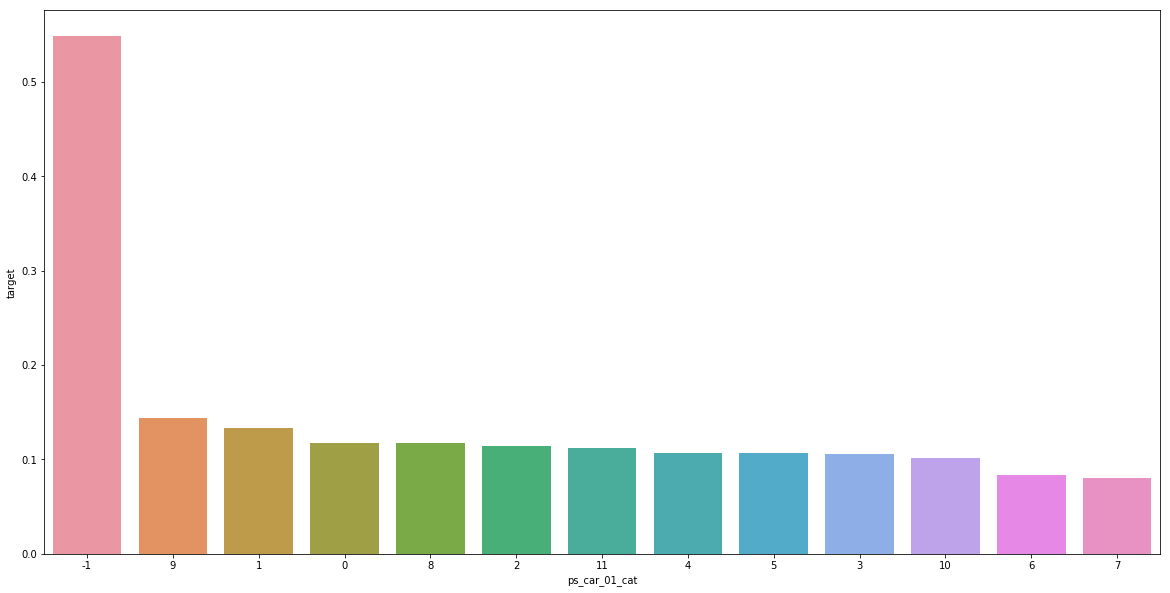

<Figure size 432x288 with 0 Axes>

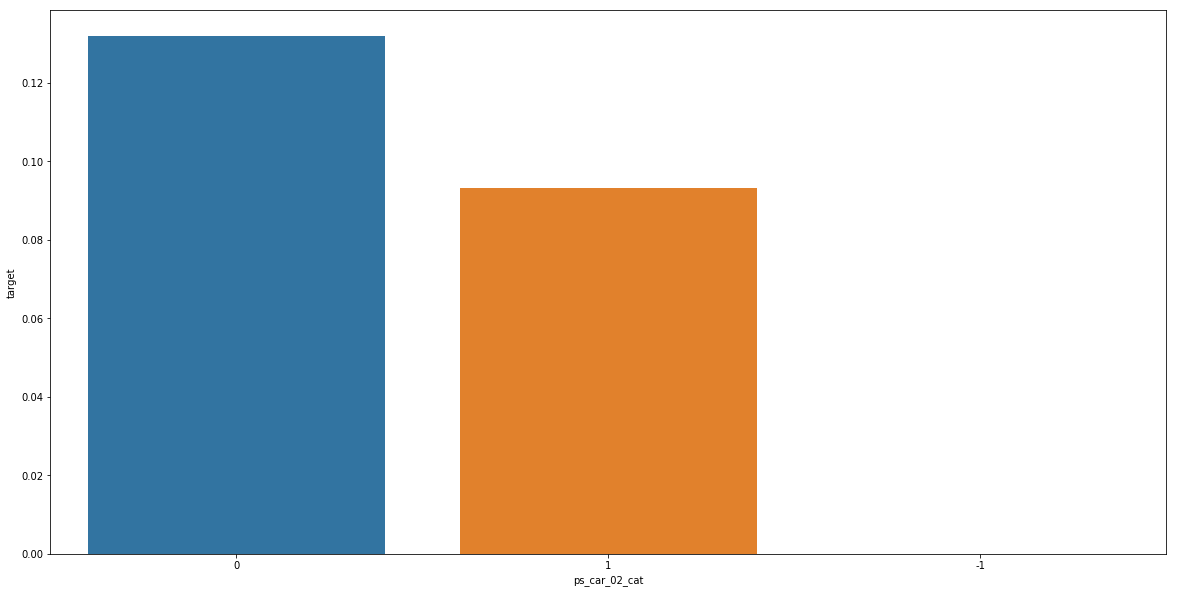

<Figure size 432x288 with 0 Axes>

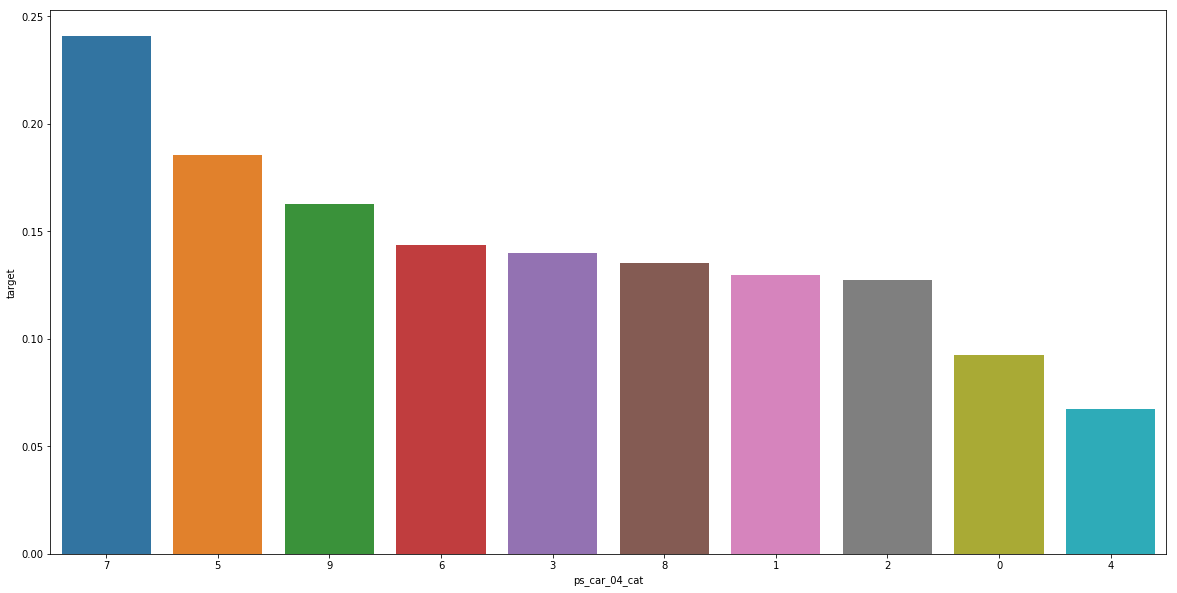

<Figure size 432x288 with 0 Axes>

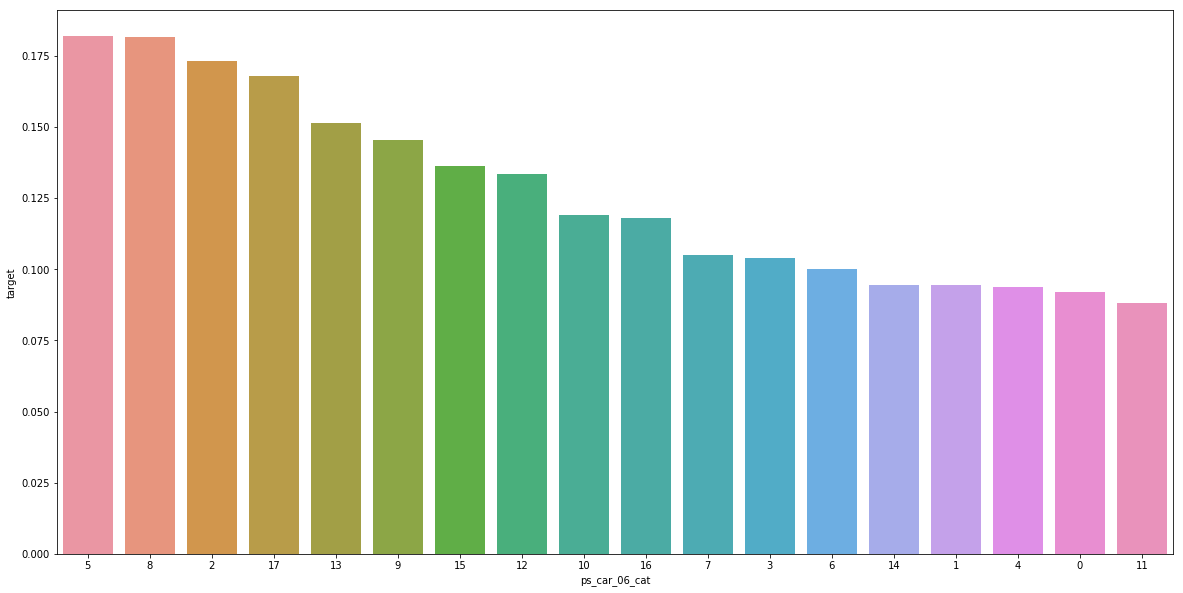

<Figure size 432x288 with 0 Axes>

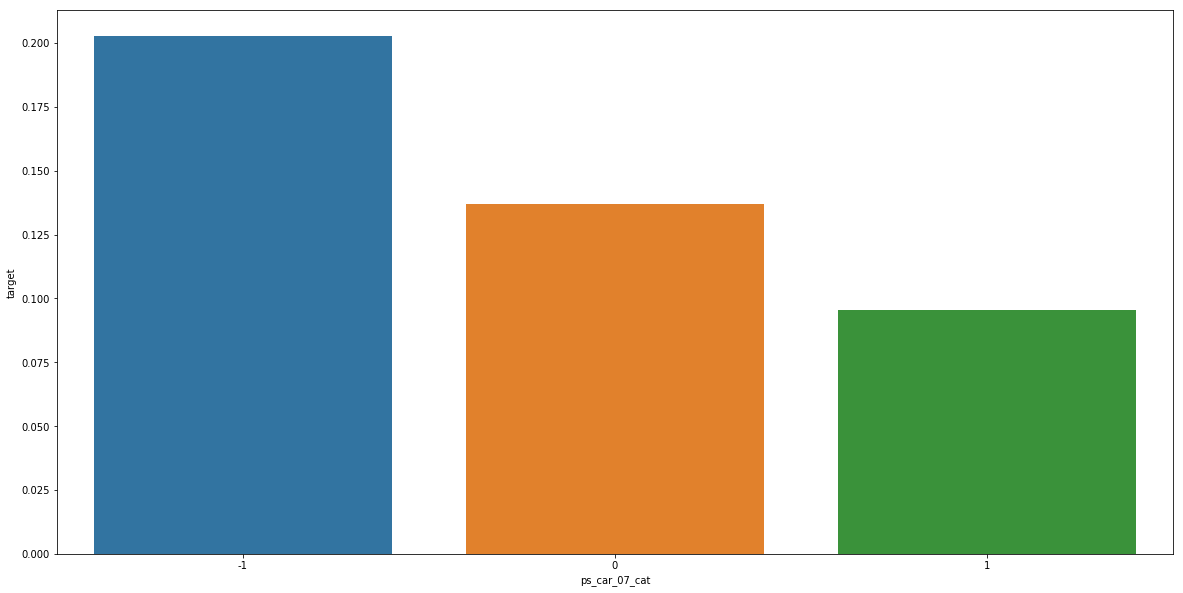

<Figure size 432x288 with 0 Axes>

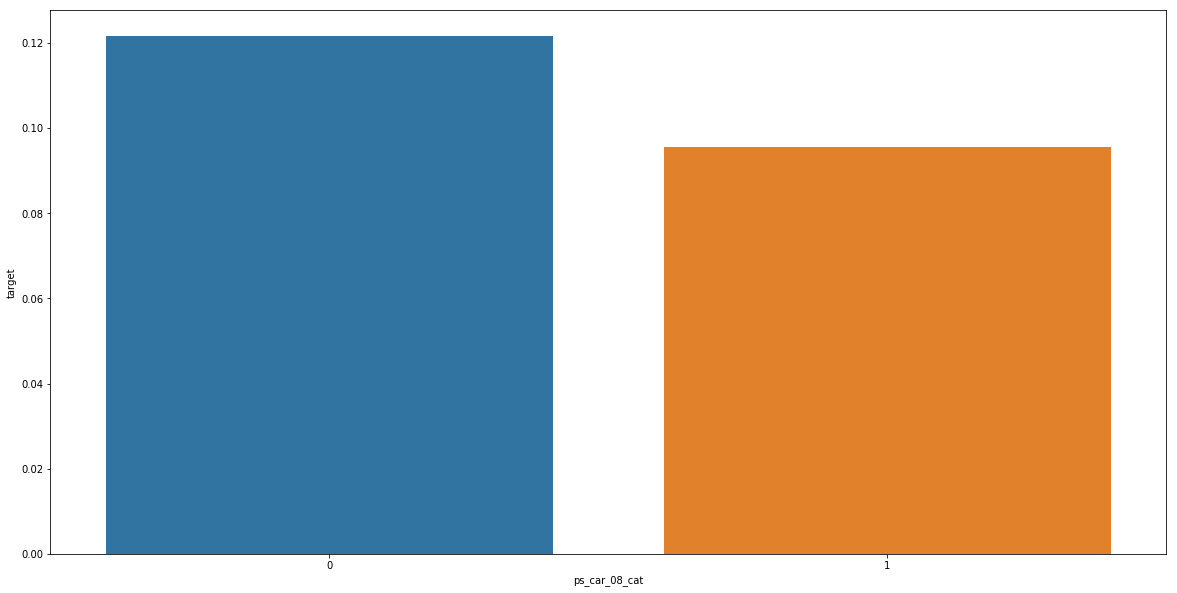

<Figure size 432x288 with 0 Axes>

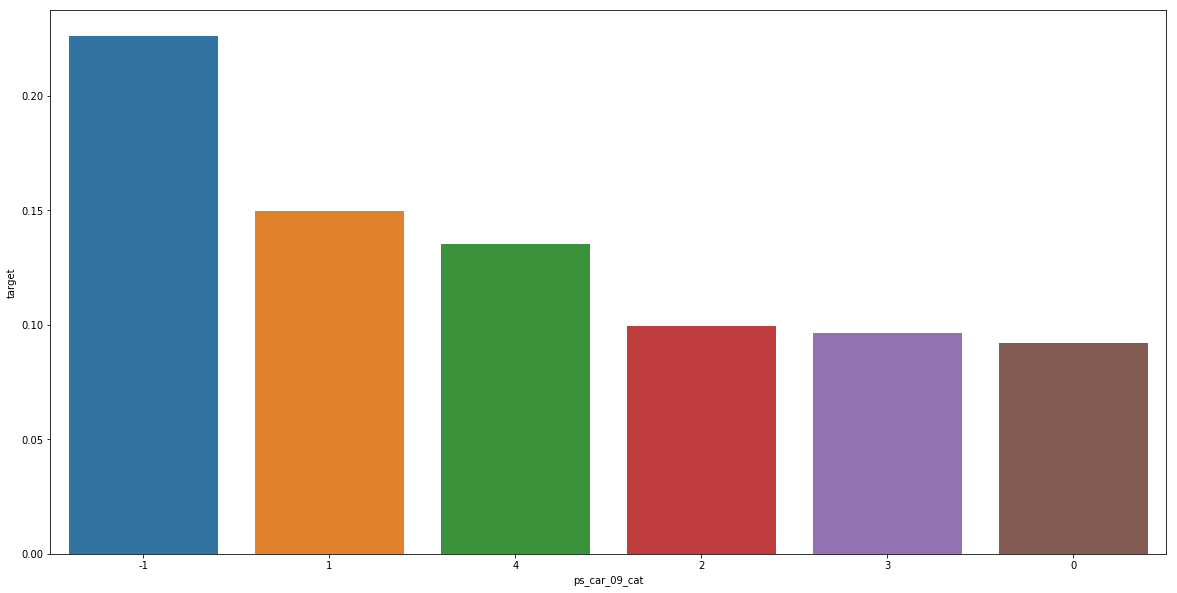

<Figure size 432x288 with 0 Axes>

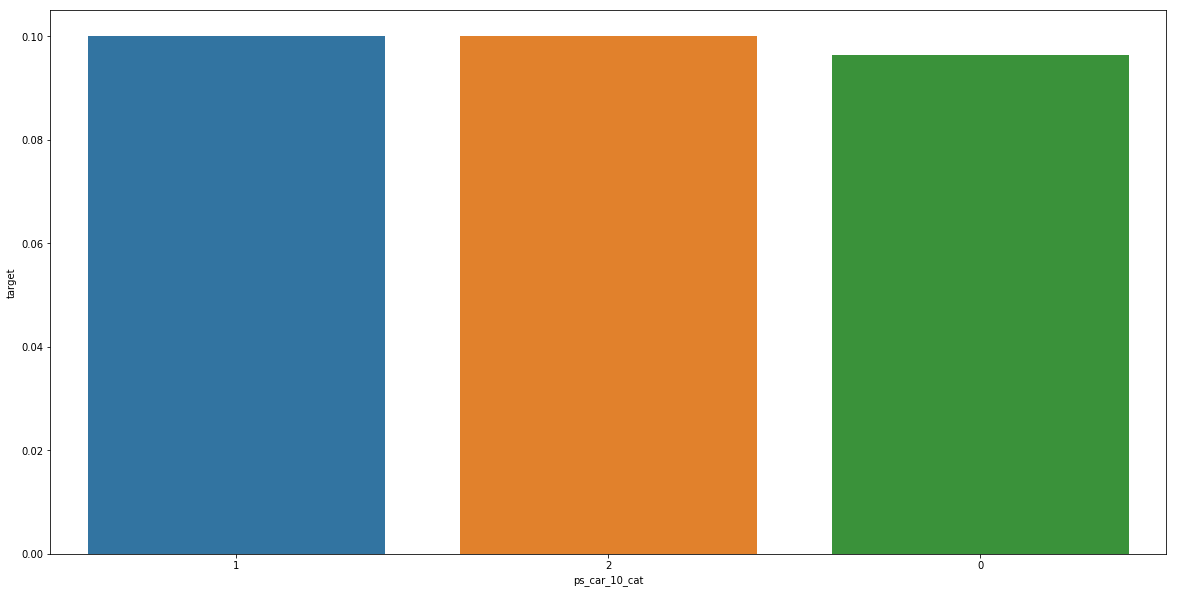

<Figure size 432x288 with 0 Axes>

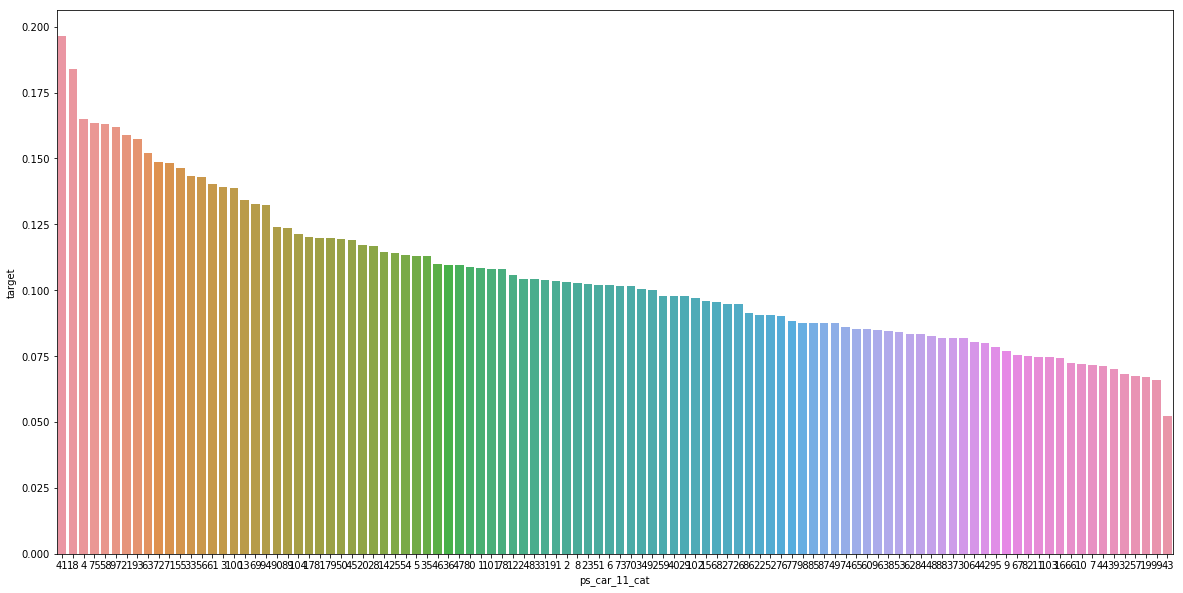

In [21]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f], as_index = False).mean()
    cat_perc.sort_values(by='target', ascending = False, inplace = True)
    #Bar Plot
    # order the bars descending
    sns.barplot(ax = ax, x = f, y = 'target', data = cat_perc,
               order = cat_perc[f])
    

As we can see from the variables with missing values, it is a good idea to keep the missing values as a separate category value, instead of replacing them by the mode for instance. The customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim.

In addition, 'ps_car_11_cat' has too many values to be encoded for dummy variables. I will have to find another way to deal with this variable.

## Binary Variables

<Figure size 432x288 with 0 Axes>

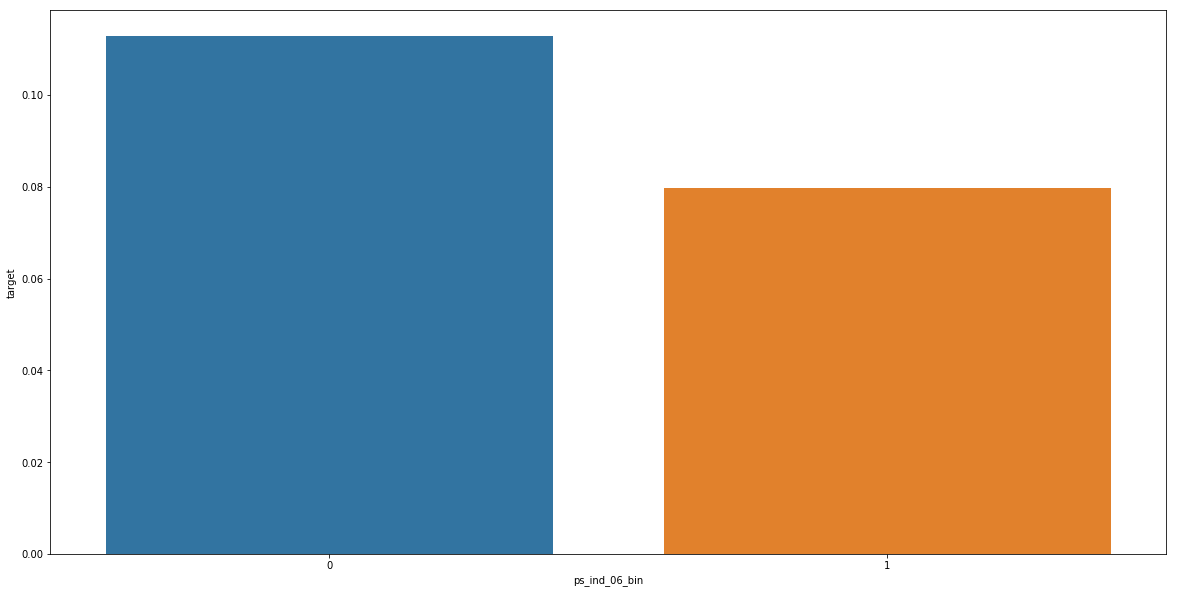

<Figure size 432x288 with 0 Axes>

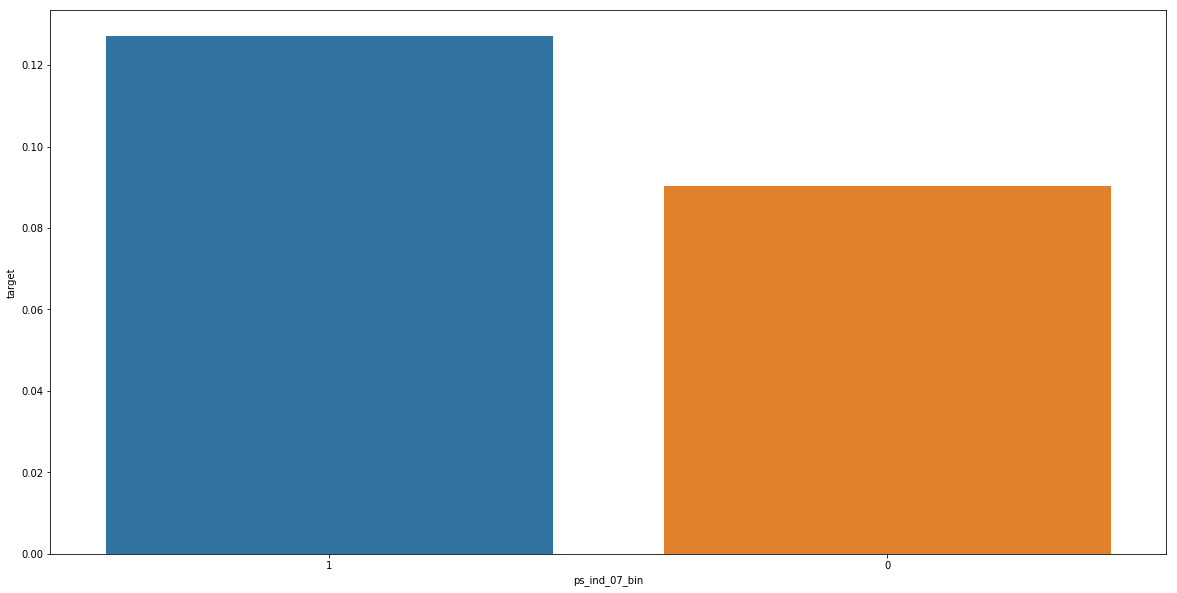

<Figure size 432x288 with 0 Axes>

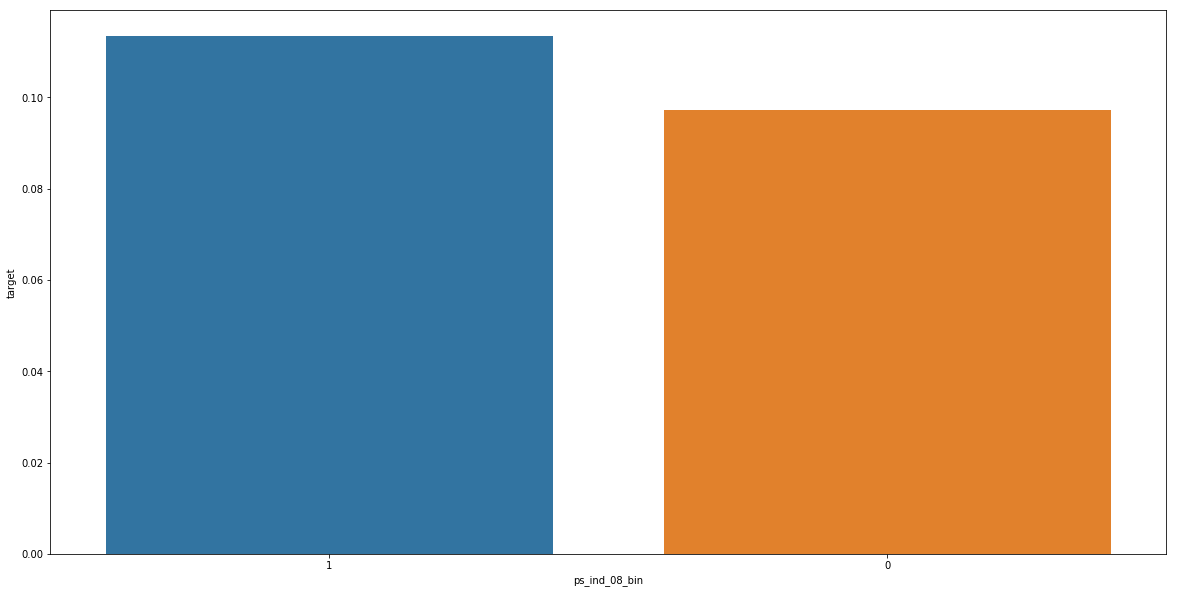

<Figure size 432x288 with 0 Axes>

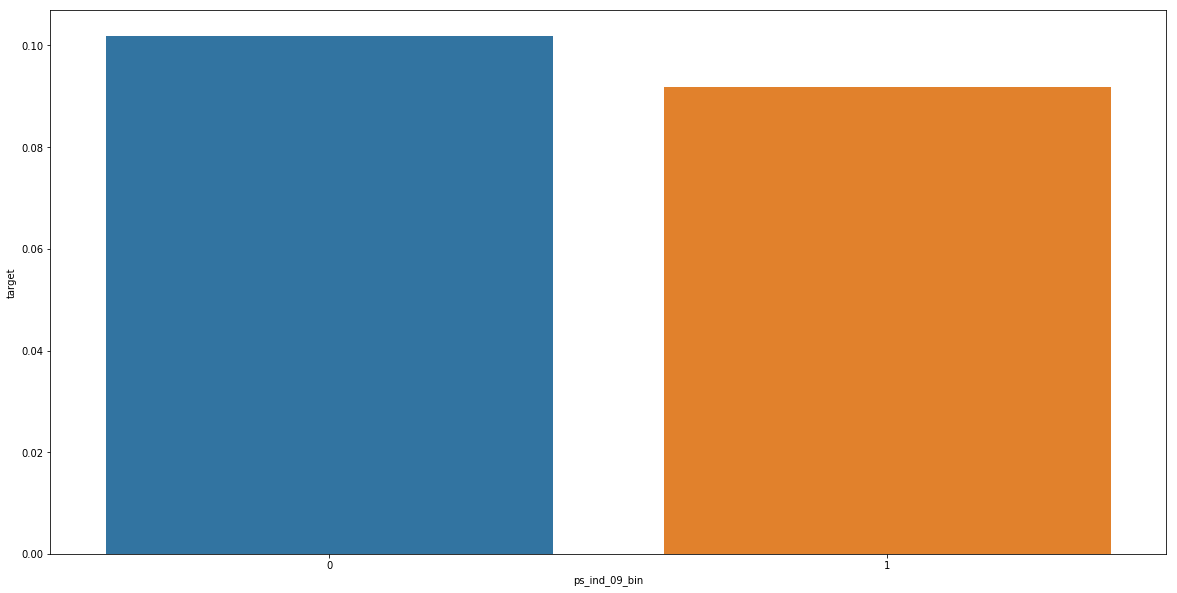

<Figure size 432x288 with 0 Axes>

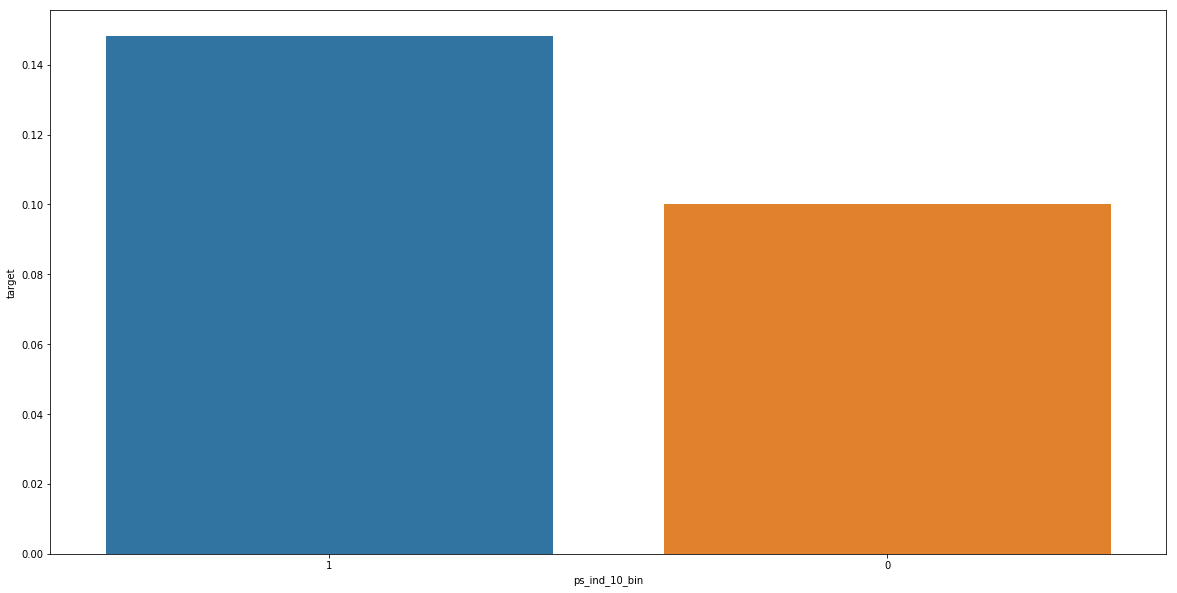

<Figure size 432x288 with 0 Axes>

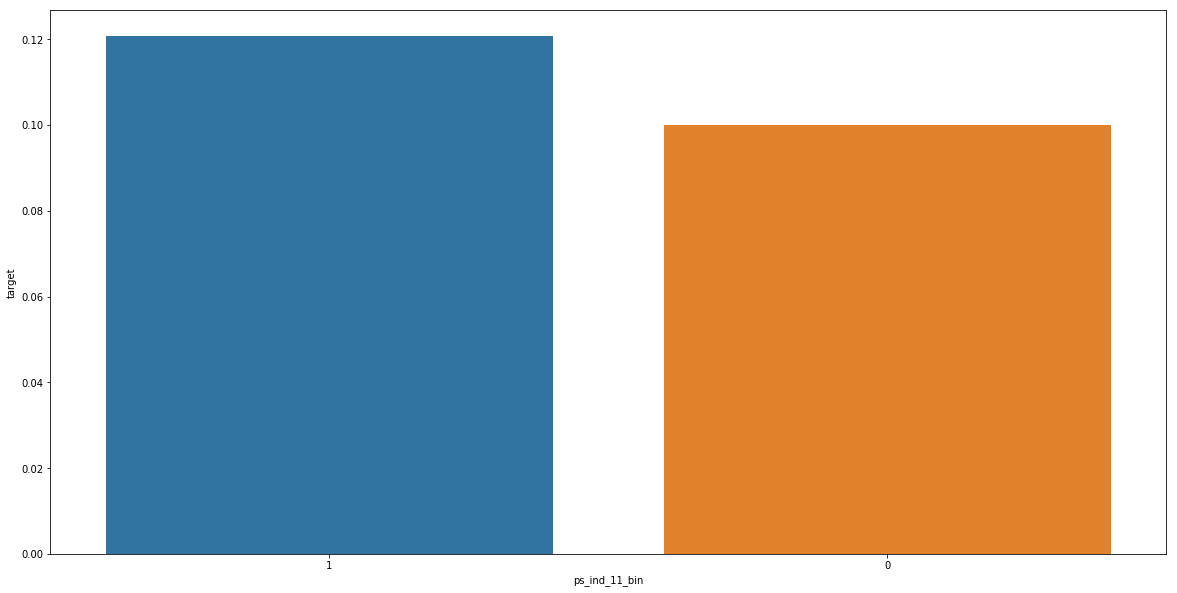

<Figure size 432x288 with 0 Axes>

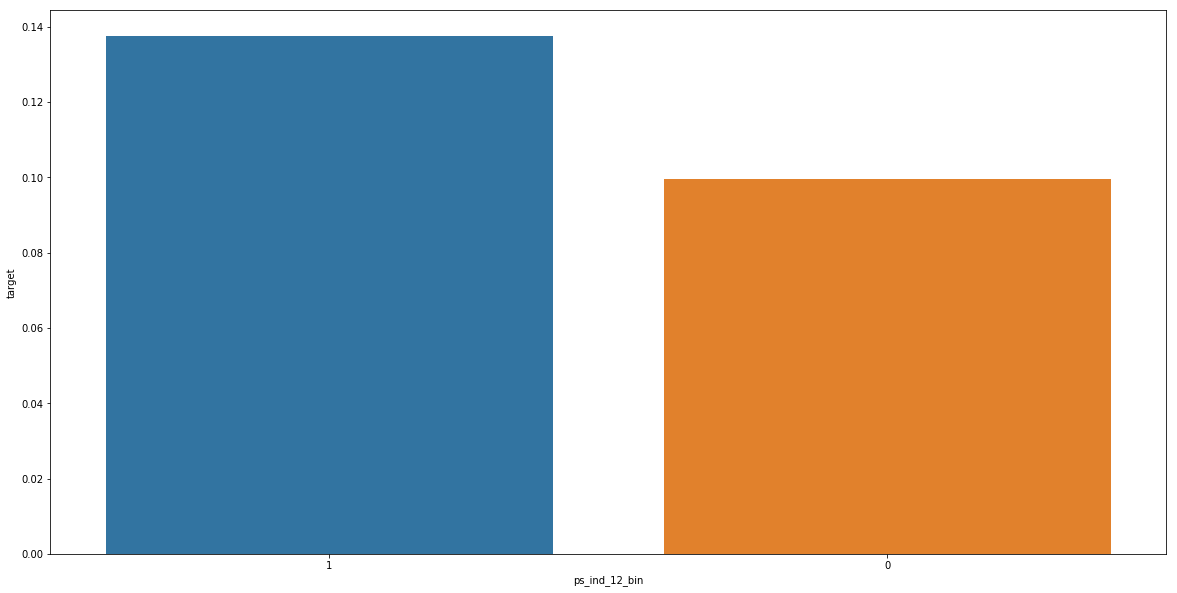

<Figure size 432x288 with 0 Axes>

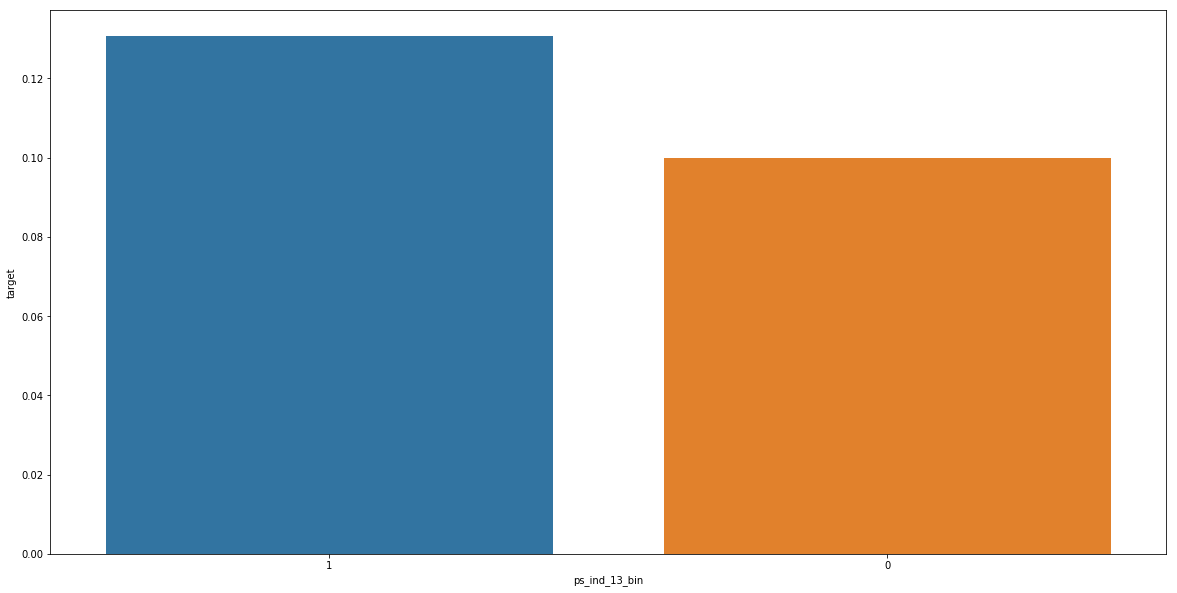

<Figure size 432x288 with 0 Axes>

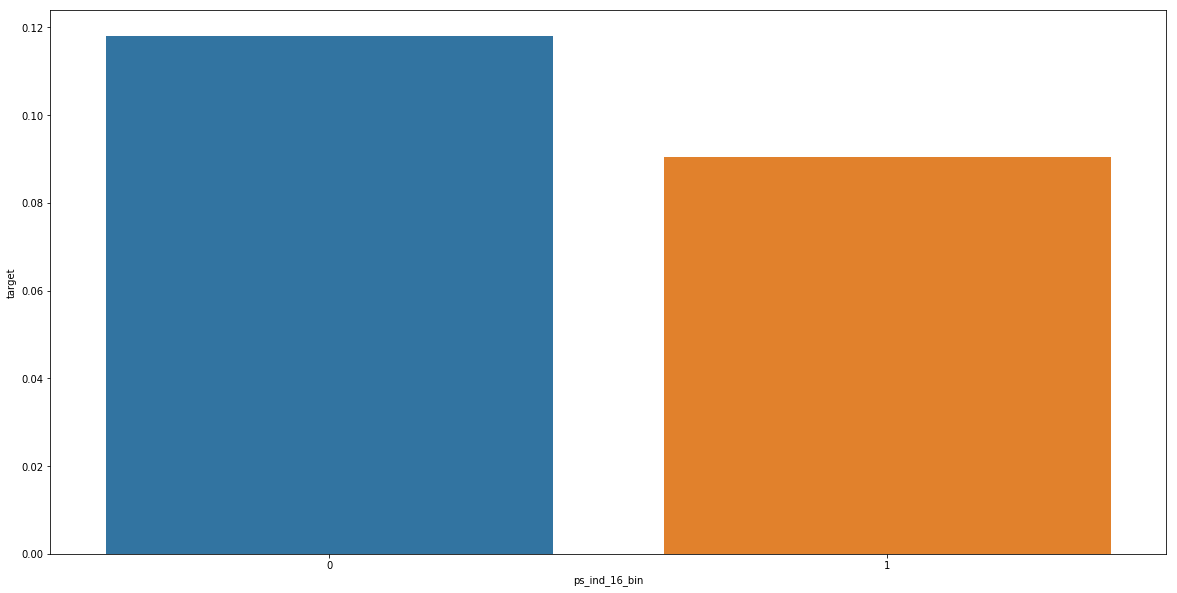

<Figure size 432x288 with 0 Axes>

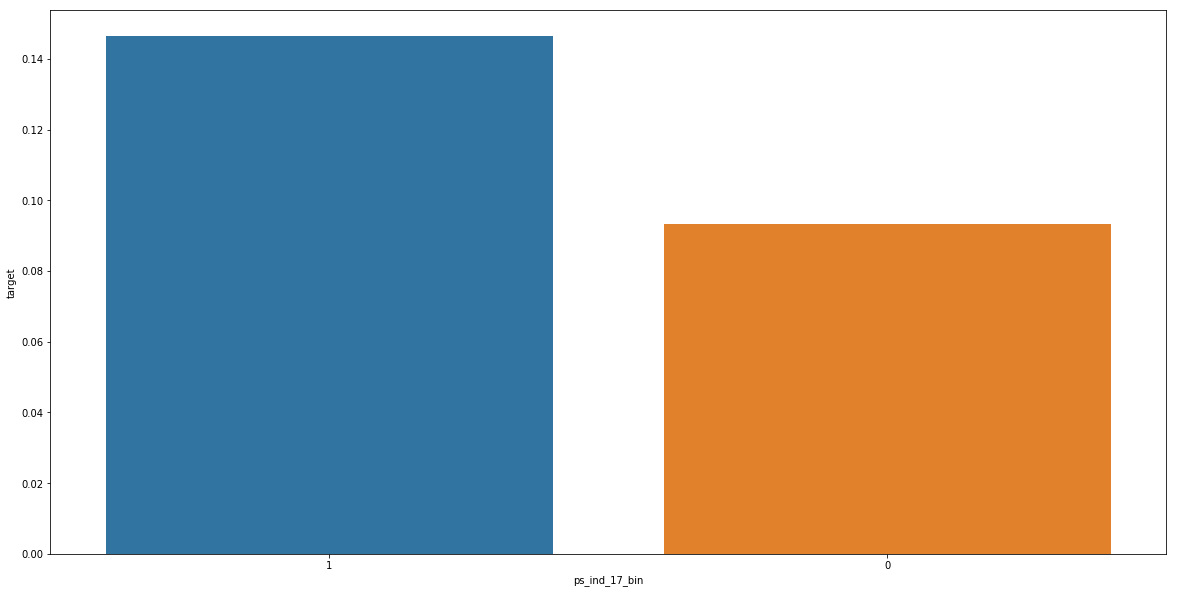

<Figure size 432x288 with 0 Axes>

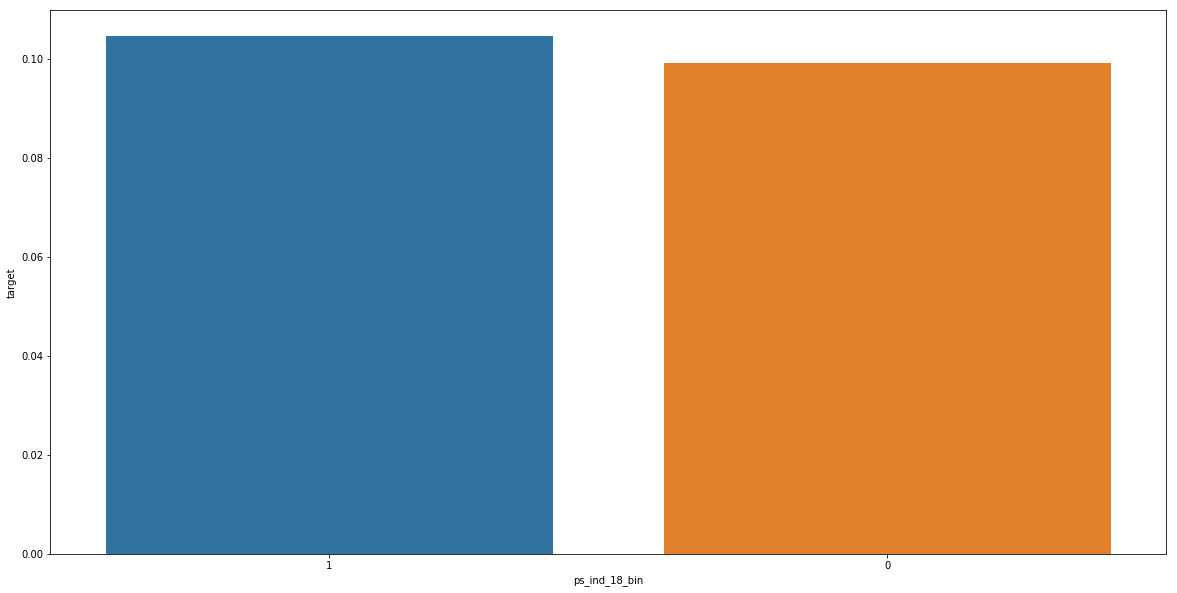

<Figure size 432x288 with 0 Axes>

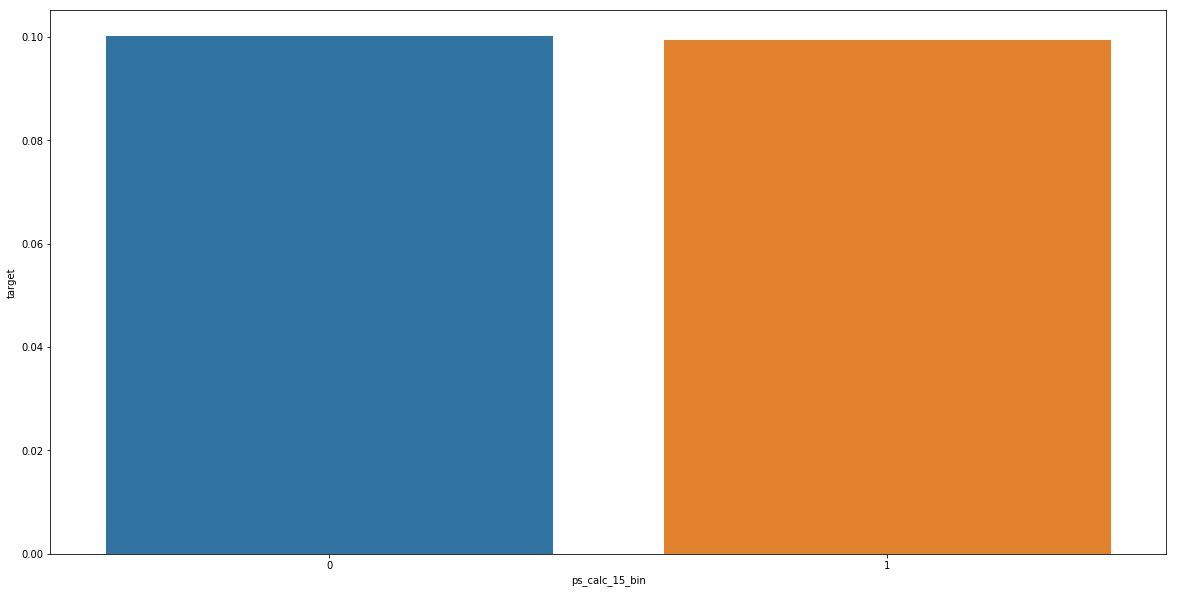

<Figure size 432x288 with 0 Axes>

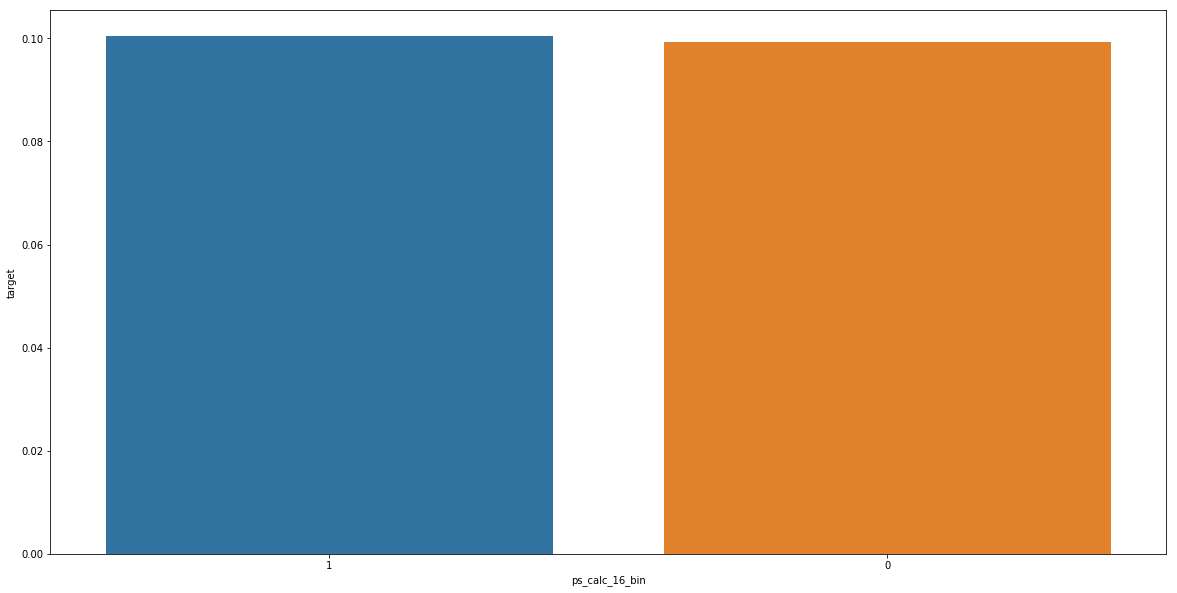

<Figure size 432x288 with 0 Axes>

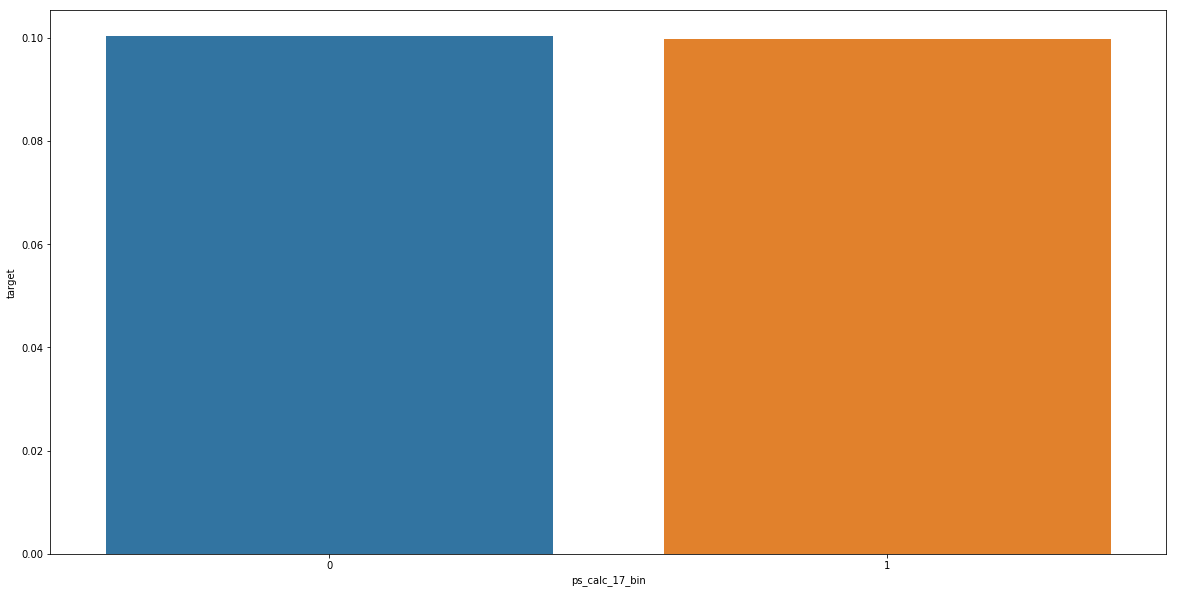

<Figure size 432x288 with 0 Axes>

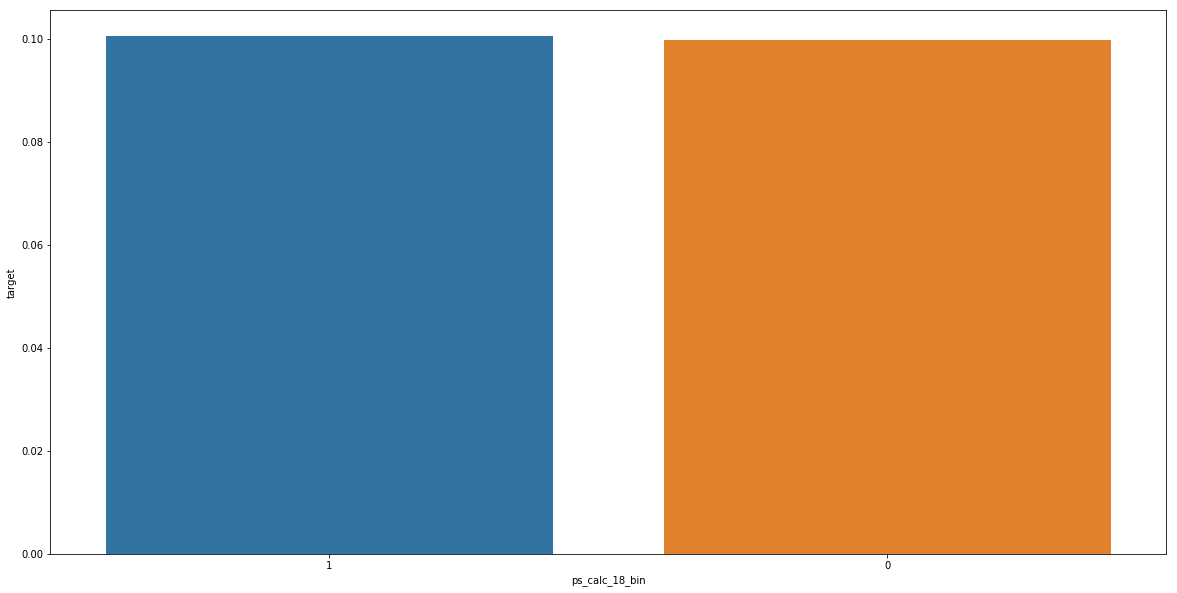

<Figure size 432x288 with 0 Axes>

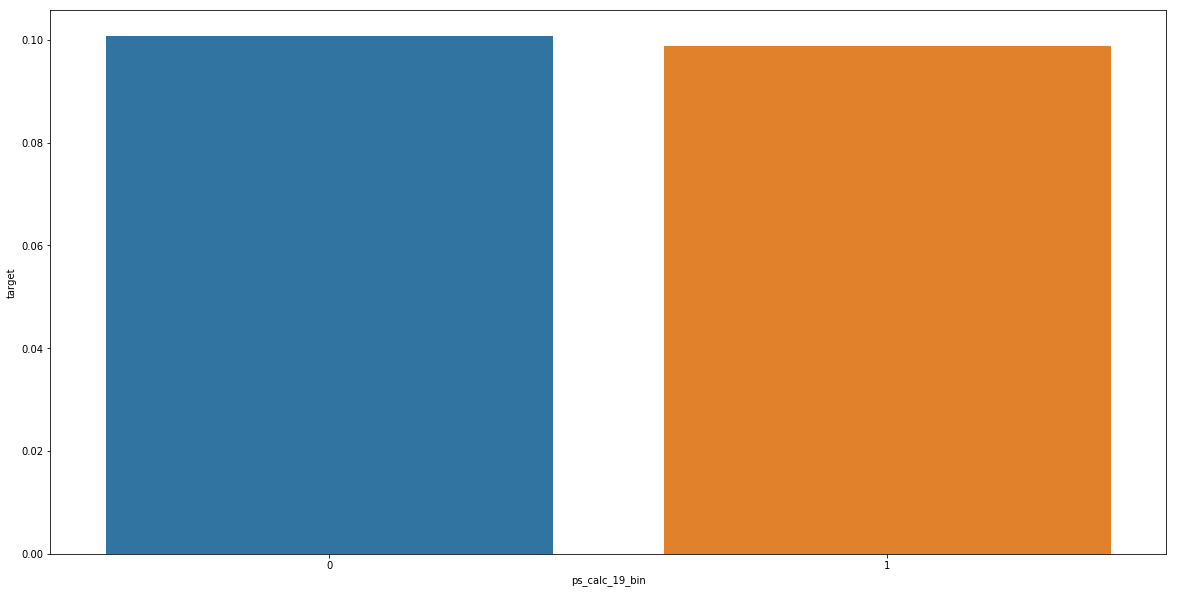

<Figure size 432x288 with 0 Axes>

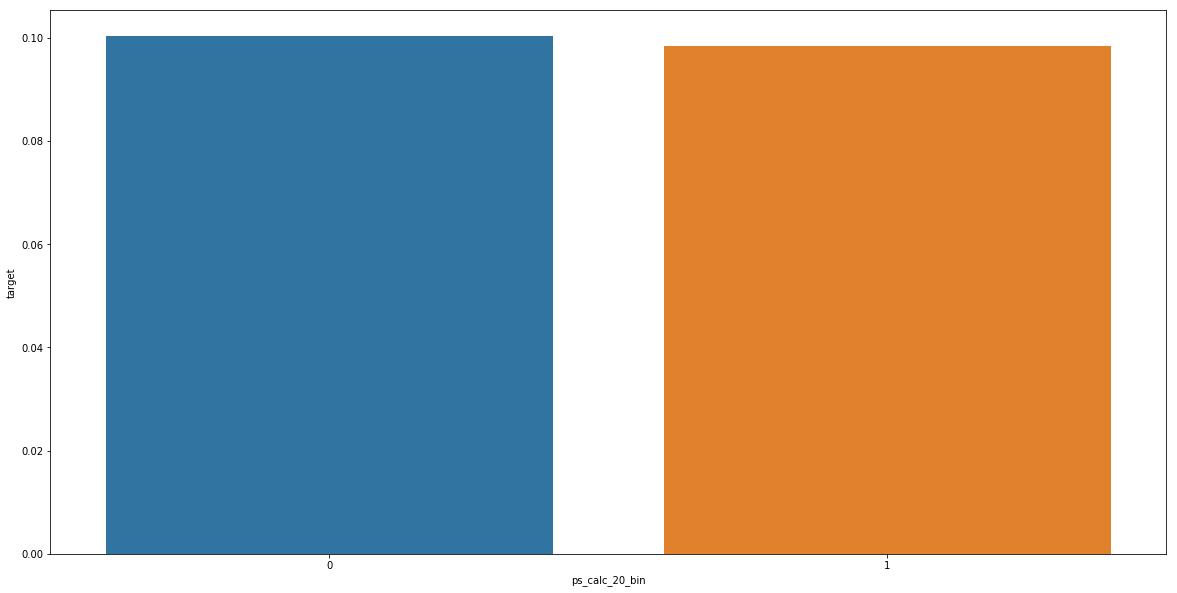

In [22]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
v = v.drop('target')

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f], as_index = False).mean()
    cat_perc.sort_values(by='target', ascending = False, inplace = True)
    #Bar Plot
    # order the bars descending
    sns.barplot(ax = ax, x = f, y = 'target', data = cat_perc,
               order = cat_perc[f])

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x103f5ab70> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x103f5ab70> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


<Figure size 432x288 with 0 Axes>

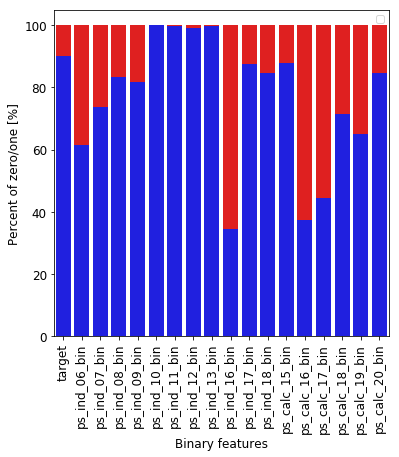

In [23]:
bin_col = meta[(meta.level == 'binary') & (meta.keep)].index
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum()/train.shape[0]*100)
    one_list.append((train[col]==1).sum()/train.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom= zero_list, color="red")
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show();

## Interval Variables

### Correlation

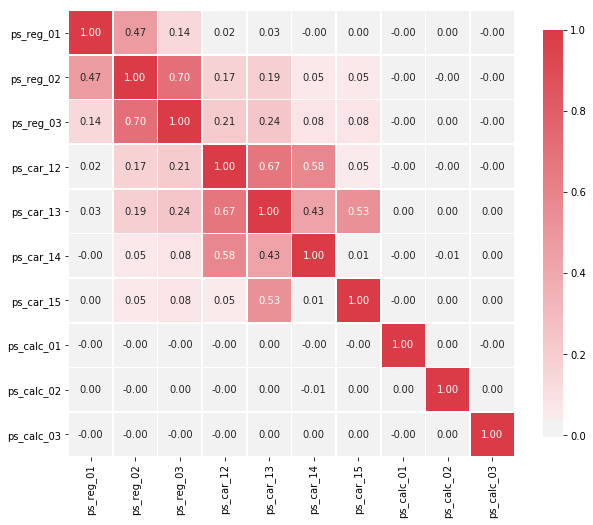

In [24]:
def corr_heatmap(v):
    correlations = train[v].corr()
    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

### Visualization

<Figure size 432x288 with 0 Axes>

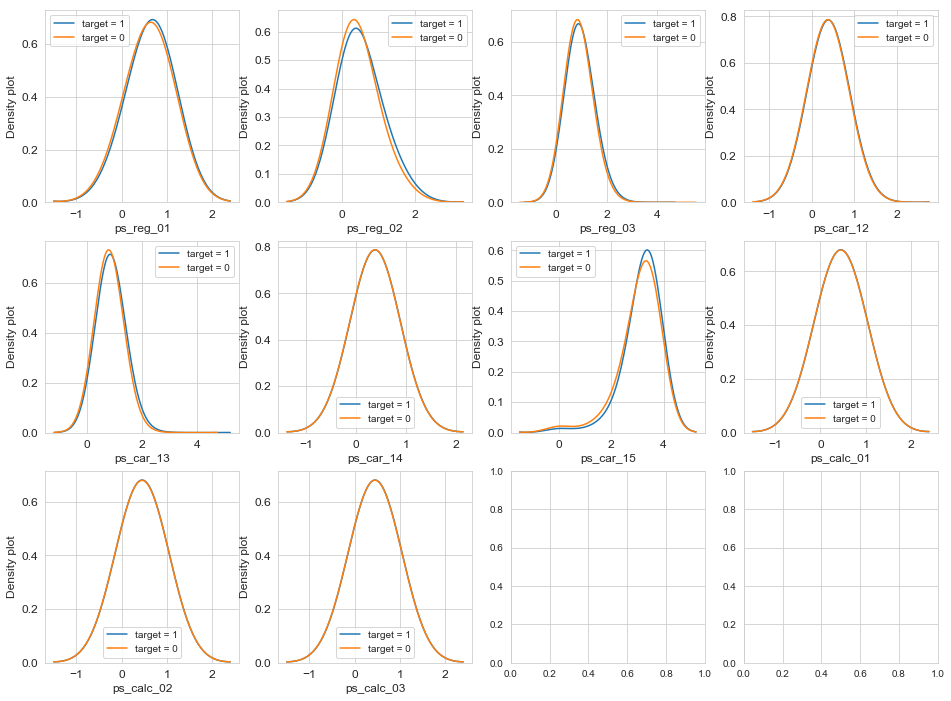

In [25]:
var = meta[(meta.level == 'interval') & (meta.keep)].index
i = 0
t1 = train.loc[train['target'] != 0]
t0 = train.loc[train['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Ordinal Variables

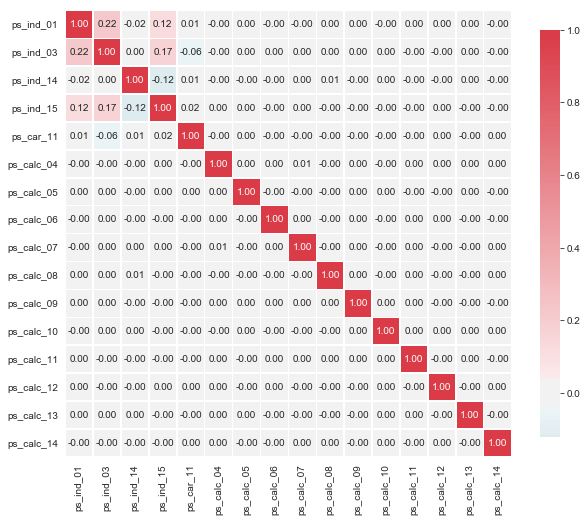

In [26]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

# Feature engineering

### Creating dummy variables

Encoding dummy variables for nominal variables.

In [27]:
v = meta[(meta.level == 'nominal') & (meta.index != 'ps_car_11_cat') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns = v, drop_first = True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


### Coming up with another way to deal with 'ps_car_11_cat'

In [28]:
train[['ps_car_11_cat']]

,ps_car_11_cat
0,26
1,104
2,15
3,74
4,78
5,27
6,11
7,10
8,102
9,80


### Hashing Encoder for dimension reduction

In [29]:
from sklearn.feature_extraction import FeatureHasher
hash_data = train[['ps_car_11_cat']].copy()
hash_data[['ps_car_11_cat']] = hash_data[['ps_car_11_cat']].astype('str')
h = FeatureHasher(n_features=10,input_type="string")
hash_result = h.transform(hash_data.values)

In [30]:
pd.DataFrame(hash_result.toarray())

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
8,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
ps_car_11_cat = pd.DataFrame(hash_result.toarray(), columns = ['11_0', '11_1', '11_2', '11_3', '11_4', '11_5', '11_6', '11_7', '11_8', '11_9'])
#train.drop(columns = 'ps_car_11_cat', inplace = True)
result = pd.concat([train, ps_car_11_cat], axis = 1)

In [32]:
result

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,...,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_1,ps_car_06_cat_2,ps_car_06_cat_3,ps_car_06_cat_4,ps_car_06_cat_5,ps_car_06_cat_6,ps_car_06_cat_7,ps_car_06_cat_8,ps_car_06_cat_9,ps_car_06_cat_10,ps_car_06_cat_11,ps_car_06_cat_12,ps_car_06_cat_13,ps_car_06_cat_14,ps_car_06_cat_15,ps_car_06_cat_16,ps_car_06_cat_17,ps_car_07_cat_0,ps_car_07_cat_1,ps_car_08_cat_1,ps_car_09_cat_0,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4,ps_car_10_cat_1,ps_car_10_cat_2,11_0,11_1,11_2,11_3,11_4,11_5,11_6,11_7,11_8,11_9
0,353762,0,1,1,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,26,1.0,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,845629,0,5,7,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,104,1.0,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1449185,0,4,3,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,15,3.0,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,834066,0,6,6,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,74,2.0,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,436189,0,5,5,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,78,3.0,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,50946,0,1,2,0,1,0,0,0,0,0,0,0,10,1,0,0,0.8,0.5,0.849264,27,3.0,0.374166,0.682061,0.390768,3.000000,0.8,0.8,0.0,3,2,6,4,8,2,6,7,1,4,8,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,145674,0,1,4,0,0,0,1,0,0,0,0,0,7,1,0,0,0.9,0.7,0.959492,11,2.0,0.316228,0.707326,0.368782,3.605551,0.0,0.2,0.9,4,1,9,4,9,2,13,4,2,2,8,0,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
7,68603,0,0,4,1,0,0,0,0,0,0,0,0,8,0,0,1,0.9,0.3,0.359687,10,2.0,0.316228,0.683135,0.376829,3.162278,0.0,0.6,0.3,2,3,8,5,10,3,9,5,2,0,7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
8,1439108,0,0,1,0,0,0,1,0,0,0,0,0,7,1,0,0,0.5,0.3,1.029259,102,2.0,0.400000,0.896849,0.374695,3.605551,0.3,0.2,0.1,3,1,7,5,9,1,10,5,3,1,8,0,1,1,0,0,0,0,1,0,0,...,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,129280,0,4,4,0,1,0,0,0,0,0,0,0,6,1,0,0,0.7,0.4,0.761988,80,2.0,0.316228,0.774385,0.374695,3.605551,0.1,0.8,0.7,1,5,10,1,9,3,7,10,0,1,9,0,1,1,1,1,0,1,0,0,0,

# Train - Test split

In [33]:
X = result.drop(['id', 'target'], axis = 1)

In [34]:
y = result['target']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.20,
                                                   stratify = y,
                                                   random_state = 1)

# Scaling the Test data

No need to scale the data for decision tree based algorithms, so pass this process!

# Modelling

First, define gini evaluation functions. The code is borrowed from the kernal (https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt)

## Logistic Regression

In [37]:
clf_log = LogisticRegression(solver = 'liblinear',
                            penalty = 'l2',
                            C = 0.001)

In [40]:
pipe_log = Pipeline([['sc', StandardScaler()],
                   ['clf', clf_log]])

In [41]:
pipe_log.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)]])

In [42]:
y_pred = pipe_log.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [43]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.500230467849735

## Random Forest


### Hyperparameter Tuning

In [121]:
rfc = RandomForestClassifier(random_state=42)

In [122]:
param_grid = { 
    'n_estimators': [10, 20, 30],
    'max_depth' : [5, 10],
    'criterion' :['gini', 'entropy']
}


In [123]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30], 'max_depth': [5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [124]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 10}

### Test Score

In [125]:
# Testset 예측
clf_rfc = RandomForestClassifier(criterion= 'gini',
                                 max_depth = 5,
                                n_estimators = 10)
clf_rfc.fit(X_train, y_train)
y_pred = clf_rfc.predict(X_test)

In [126]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

## AdaBoost

In [52]:
tree = DecisionTreeClassifier(criterion = 'entropy',
                             random_state = 1,
                             max_depth = 1)

In [53]:
ada = AdaBoostClassifier(base_estimator = tree,
                        n_estimators = 100,
                        learning_rate = 0.1,
                        random_state = 1)

In [54]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
          learning_rate=0.1, n_estimators=100, random_state=1)

In [55]:
y_pred = ada.predict(X_test)

In [56]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5